## Building model for used cars price prediction
### Action plan:
1. Loas data 
2. Freature engineering - generate new features
3. Featire transform
4. Make pipline
5. Fit and tuning models
6. Interpret result

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

import itertools

from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

import statsmodels.api as sm

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

#from xgboost import XGBRegressor

In [3]:
sorted(glob('../../data/1_automarket_exploration/source_data/clean_data_offer_used*'))

['../../data/1_automarket_exploration/source_data/clean_data_offer_used 2020-03-02 20:04.csv',
 '../../data/1_automarket_exploration/source_data/clean_data_offer_used 2020-03-03 17:14.csv',
 '../../data/1_automarket_exploration/source_data/clean_data_offer_used 2020-09-04 13:17.csv',
 '../../data/1_automarket_exploration/source_data/clean_data_offer_used 2020-10-19 19:10.csv',
 '../../data/1_automarket_exploration/source_data/clean_data_offer_used 2020-10-19 19:12.csv']

### 1. Load data

In [4]:
# load data clean_data_offer_used 2020-03-03 17:09.csv
offer_data = pd.read_csv('../../data/1_automarket_exploration/source_data/clean_data_offer_used 2020-10-19 19:12.csv', index_col=0)

In [5]:
offer_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 244659 entries, 0 to 246323
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   producer               244659 non-null  object 
 1   model_name             244659 non-null  object 
 2   price                  244659 non-null  int64  
 3   age                    244659 non-null  int64  
 4   kmage                  244659 non-null  int64  
 5   region                 244659 non-null  object 
 6   engine_volume          244659 non-null  float64
 7   engine_power           244659 non-null  float64
 8   fuel                   244659 non-null  object 
 9   gear                   244659 non-null  object 
 10  case                   244659 non-null  object 
 11  drive_type             244659 non-null  object 
 12  color                  244659 non-null  object 
 13  offer_count_by_region  244659 non-null  int64  
 14  lat                    244659 non-nu

## 2. Feature engineering

In [6]:
category_columns = [col_name  for col_name in offer_data.columns if offer_data[col_name].dtype == 'object']
print(category_columns)
numeric_columns = [col_name  for col_name in offer_data.columns if offer_data[col_name].dtype != 'object']
print(numeric_columns)

['producer', 'model_name', 'region', 'fuel', 'gear', 'case', 'drive_type', 'color', 'macro_name', 'origin_of_producer', 'platform']
['price', 'age', 'kmage', 'engine_volume', 'engine_power', 'offer_count_by_region', 'lat', 'lng', 'specific_power']


In [7]:
offer_data[category_columns].describe().T

,count,unique,top,freq
producer,244659,12,LADA,40058
model_name,244659,1513,LADA (ВАЗ) 2115,3694
region,244659,4287,Москва,36251
fuel,244659,4,Бензин,213769
gear,244659,4,механика,114382
case,244659,19,седан,102459
drive_type,244659,3,передний,149909
color,244659,16,чёрный,58264
macro_name,244659,289,Москва,37013
origin_of_producer,244659,6,Japan,57313


In [8]:
offer_data[numeric_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
price,244659.0,668109.248558,636712.786976,9000.000000,269000.000000,500000.000000,839000.000000,9.800000e+06
age,244659.0,2009.941085,5.408746,1990.000000,2007.000000,2011.000000,2014.000000,2.019000e+03
kmage,244659.0,139531.335406,85909.282204,1.000000,80000.000000,128500.000000,183800.000000,9.999990e+05
engine_volume,244659.0,2.014756,0.722566,0.800000,1.600000,1.700000,2.000000,6.600000e+00
engine_power,244659.0,140.537458,60.893459,45.000000,98.000000,124.000000,167.000000,6.100000e+02
offer_count_by_region,244659.0,7761.495428,12511.295958,1.000000,313.000000,1589.000000,6570.000000,3.641800e+04
lat,244659.0,54.211054,4.794097,13.062550,52.591257,55.753215,56.414927,7.593638e+01
lng,244659.0,46.455883,16.543596,-90.070381,37.622504,39.736375,50.101783,1.625825e+02
specific_power,244659.0,69.170906,13.736938,27.692308,61.250000,69.285714,76.000000,1.400000e+02


## Make some transformations

In [65]:
offer_data['log_price'] = np.log(offer_data['price'])
offer_data['log_kmage'] = np.log(offer_data['kmage'])
offer_data['log_age'] = np.log(offer_data['age'])
offer_data['inverse_log_kmage'] = np.log(1/ offer_data['kmage'])

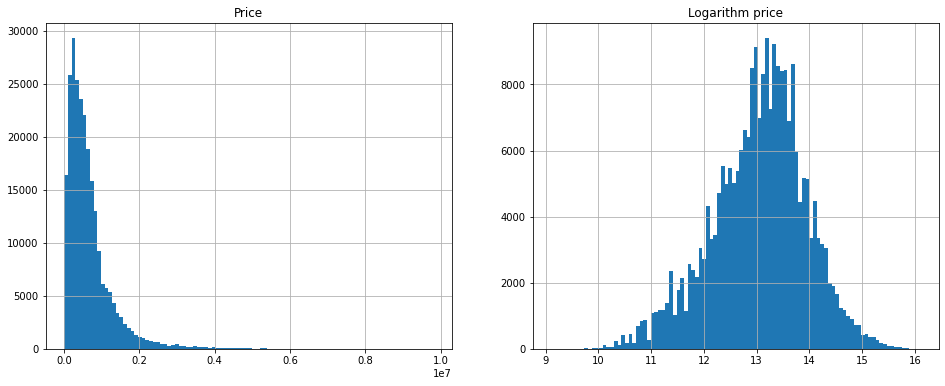

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
offer_data['price'].hist(bins=100, ax=axs[0])
axs[0].set_title('Price');

np.log(offer_data['price']).hist(bins=100, ax=axs[1])
axs[1].set_title('Logarithm price')
plt.show()

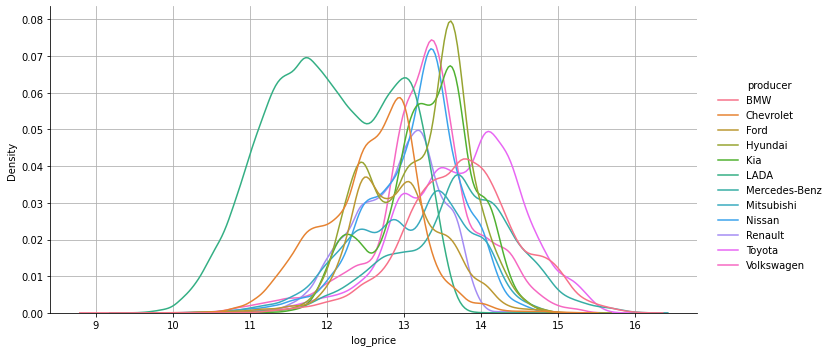

In [18]:
sns.displot(x='log_price', hue='producer', data=offer_data, kind='kde', aspect=2)
plt.grid();

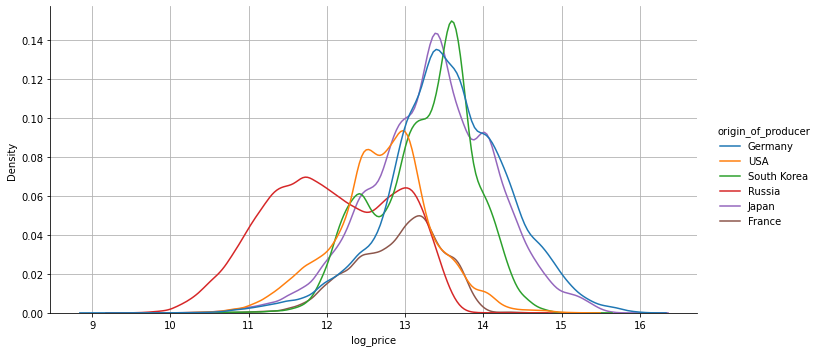

In [20]:
sns.displot(x='log_price', hue='origin_of_producer', data=offer_data, kind='kde', aspect=2)
plt.grid();

In [35]:
offer_data['macro_name'].value_counts(normalize=True).cumsum().head(80)

Москва                   0.151284
Санкт-Петербург          0.215153
Московская область       0.265905
Свердловская область     0.312942
Краснодарский край       0.344116
                           ...   
Архангельская область    0.914142
Смоленская область       0.917567
Севастополь              0.920910
Иркутск                  0.924233
Брянская область         0.927315
Name: macro_name, Length: 80, dtype: float64

In [38]:
offer_data['region'].value_counts(normalize=True).cumsum().head(50)

Москва              0.148169
Санкт-Петербург     0.210227
Екатеринбург        0.241389
Краснодар           0.268108
Нижний Новгород     0.286730
Ростов-на-Дону      0.304199
Воронеж             0.321427
Казань              0.337895
Красноярск          0.354007
Уфа                 0.369931
Челябинск           0.385451
Самара              0.397692
Тюмень              0.407960
Новосибирск         0.418076
Саратов             0.428143
Волгоград           0.437948
Пермь               0.447100
Тула                0.455442
Ярославль           0.463183
Брянск              0.470631
Пенза               0.477661
Сочи                0.484654
Белгород            0.491562
Ставрополь          0.498428
Тверь               0.504870
Омск                0.510981
Липецк              0.517063
Рязань              0.523132
Калуга              0.529153
Киров               0.535173
Ульяновск           0.541080
Чебоксары           0.546974
Смоленск            0.552814
Калининград         0.558426
Курск         

In [32]:
for cat in category_columns:
    display(offer_data[cat].value_counts(normalize=True).cumsum().head(20))

LADA             0.163730
Hyundai          0.259639
Toyota           0.349082
Volkswagen       0.437997
Kia              0.526611
Nissan           0.611177
Chevrolet        0.686629
BMW              0.759633
Renault          0.823742
Mercedes-Benz    0.885633
Mitsubishi       0.945880
Ford             1.000000
Name: producer, dtype: float64

LADA (ВАЗ) 2115                       0.015099
Chevrolet Lanos I                     0.030070
LADA (ВАЗ) 2114                       0.045038
LADA (ВАЗ) 2112                       0.060002
LADA (ВАЗ) 2107                       0.074724
LADA (ВАЗ) 2110                       0.088912
LADA (ВАЗ) Largus I                   0.102526
LADA (ВАЗ) Granta I                   0.115504
LADA (ВАЗ) Vesta I                    0.127169
LADA (ВАЗ) 2121 (4x4) I Рестайлинг    0.138585
LADA (ВАЗ) Priora I                   0.149898
Chevrolet Lacetti                     0.160848
LADA (ВАЗ) Kalina I                   0.171005
Chevrolet Niva I Рестайлинг           0.181101
Renault Duster I                      0.190682
Kia Spectra I Рестайлинг 2            0.199273
Hyundai ix35 I                        0.207787
Volkswagen Tiguan I Рестайлинг        0.215884
Volkswagen Polo V                     0.223736
Hyundai Accent  II ТагАЗ              0.231567
Name: model_name, dtype: float64

Москва             0.148169
Санкт-Петербург    0.210227
Екатеринбург       0.241389
Краснодар          0.268108
Нижний Новгород    0.286730
Ростов-на-Дону     0.304199
Воронеж            0.321427
Казань             0.337895
Красноярск         0.354007
Уфа                0.369931
Челябинск          0.385451
Самара             0.397692
Тюмень             0.407960
Новосибирск        0.418076
Саратов            0.428143
Волгоград          0.437948
Пермь              0.447100
Тула               0.455442
Ярославль          0.463183
Брянск             0.470631
Name: region, dtype: float64

Бензин    0.873743
Дизель    0.996779
Гибрид    0.999706
Газ       1.000000
Name: fuel, dtype: float64

механика    0.467516
автомат     0.881451
вариатор    0.955293
робот       1.000000
Name: gear, dtype: float64

седан                      0.418783
внедорожник 5 дв.          0.737717
хэтчбек 5 дв.              0.877241
универсал 5 дв.            0.923890
минивэн                    0.941134
внедорожник 3 дв.          0.956842
компактвэн                 0.966038
хэтчбек 3 дв.              0.974618
лифтбек                    0.982065
пикап двойная кабина       0.988895
фургон                     0.993685
купе                       0.998018
купе-хардтоп               0.999424
кабриолет                  0.999787
пикап одинарная кабина     0.999865
пикап полуторная кабина    0.999922
седан-хардтоп              0.999959
лимузин                    0.999980
внедорожник открытый       1.000000
Name: case, dtype: float64

передний    0.612726
полный      0.917853
задний      1.000000
Name: drive_type, dtype: float64

чёрный         0.238144
белый          0.424276
серебристый    0.597558
серый          0.715813
синий          0.797833
красный        0.846190
коричневый     0.887607
зелёный        0.926678
бежевый        0.952350
голубой        0.967015
золотистый     0.975729
пурпурный      0.984444
фиолетовый     0.991535
оранжевый      0.996718
жёлтый         0.999767
розовый        1.000000
Name: color, dtype: float64

Москва                               0.151284
Санкт-Петербург                      0.215153
Московская область                   0.265905
Свердловская область                 0.312942
Краснодарский край                   0.344116
Республика Татарстан                 0.371542
Краснодар                            0.398260
Республика Башкортостан              0.423769
Нижний Новгород                      0.442391
Ростов-на-Дону                       0.459860
Воронеж                              0.477089
Красноярск                           0.493201
Челябинск                            0.508720
Ростовская область                   0.523484
Ставропольский край                  0.536522
Республика Крым                      0.549450
Самара                               0.561708
Ханты-Мансийский автономный округ    0.572131
Челябинская область                  0.582472
Тюмень                               0.592739
Name: macro_name, dtype: float64

Japan          0.234257
Germany        0.458066
South Korea    0.642588
Russia         0.806318
USA            0.935890
France         1.000000
Name: origin_of_producer, dtype: float64

Volkswagen Passat    0.018090
Nissan Almera        0.035024
LADA 2115            0.050123
Chevrolet Lanos      0.065095
LADA Granta          0.080067
Renault Duster       0.095034
Nissan Qashqai       0.110002
Toyota RAV4          0.124970
Chevrolet Niva       0.139938
Hyundai Solaris      0.154905
LADA 2114            0.169873
Ford Focus           0.184837
LADA 2112            0.199801
Nissan X-Trail       0.214764
Volkswagen Polo      0.229728
Kia Rio              0.244692
Kia Ceed             0.259655
LADA 2110            0.274619
LADA Kalina          0.289583
Kia Sportage         0.304542
Name: platform, dtype: float64

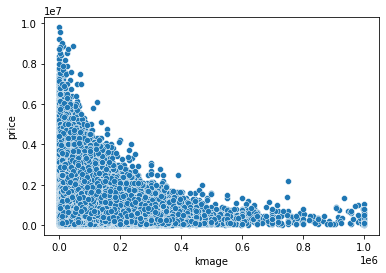

In [62]:
sns.scatterplot(x='kmage', y='price', data=offer_data);

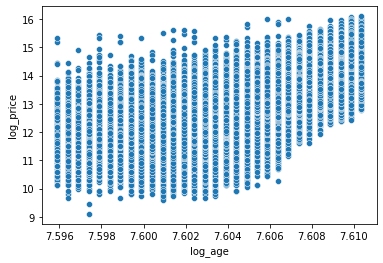

In [66]:
sns.scatterplot(x='log_age', y='log_price', data=offer_data);

## 2.2 Offer counts
We have total car count in region, but we can add count of current model or brand that could dtermine servise aviability in each region or customer preference.


In [10]:
# количество авто данной модели всего
offer_count_model = offer_data['model_name'].value_counts().to_frame().reset_index()
offer_count_model.columns = ['model_name', 'offer_count_by_model']

In [11]:
# количество авто данной модели в регионе
offer_count_model_macro_region = offer_data.groupby(['model_name', 'macro_name'], as_index=False)\
                                           .count()[['model_name', 'macro_name', 'producer']]
offer_count_model_macro_region.columns = ['model_name', 'macro_name', 'offer_count_by_model_macro_region']

In [12]:
# количество авто данной производителя в регионе
offer_count_prod_macro_region = offer_data.groupby(['producer', 'macro_name'], as_index=False)\
                                           .count()[['producer', 'macro_name', 'model_name']]
offer_count_prod_macro_region.columns = ['producer', 'macro_name', 'offer_count_by_prod_macro_region']

In [67]:
offer_data.shape

(244659, 27)

In [13]:
offer_data = pd.merge(offer_data, offer_count_model, on='model_name')
offer_data = pd.merge(offer_data, offer_count_model_macro_region, on=['model_name', 'macro_name'])
offer_data = pd.merge(offer_data, offer_count_prod_macro_region, on=['producer', 'macro_name'])

In [14]:
offer_data.head(1).T

,0
producer,BMW
model_name,BMW 1 серия II (F20/F21) 116i
price,850000
age,2012
kmage,81000
region,Одинцово
engine_volume,1.6
engine_power,136
fuel,Бензин
gear,автомат


## Categorical encoding

In [139]:
comb = [list(c) for c in itertools.combinations(category_columns + ['age'], 2)]

In [147]:
for c in comb:
    name = '_'.join(c)
    offer_data[f'mean_price_{name}'] = offer_data.groupby(c)['price'].transform('mean')
    offer_data[f'std_price_{name}'] = offer_data.groupby(c)['price'].transform('std').fillna(-1)
    offer_data[f'min_price_{name}'] = offer_data.groupby(c)['price'].transform('min')
    offer_data[f'max_price_{name}'] = offer_data.groupby(c)['price'].transform('max')

## TODO: 
1. Process category features: top - other
2. Add some grouped features: mean, max, min, std by group
3. Cluster by coordinates


### 2.1 Feature transform

In [149]:
y_col = 'price'

X_data = offer_data.drop(columns=[y_col, 'log_price'])
y_data = offer_data[y_col]

enc = OrdinalEncoder()
X_data[category_columns] = enc.fit_transform(X_data[category_columns])

### 3.1 Train test split

In [150]:
%%time

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, 
                                                    test_size=0.4, random_state=42)

X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, 
                                                    test_size=0.5, random_state=42)

CPU times: user 504 ms, sys: 561 ms, total: 1.07 s
Wall time: 1.07 s


In [151]:
print(X_data.shape)
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

(244659, 289)
(146795, 289)
(48932, 289)
(48932, 289)


## 3. Model fitting
### 3.1. Baseline constant model

In [144]:
y_pred_const = pd.Series(y_train.median(), index=y_test.index)

In [82]:
print("Mean Absolute Error : {:.2f}".format(mean_absolute_error(y_test, y_pred_const)))

Mean Absolute Error : 394129.23


### Resume:
Constant model error on 394k in price of car

In [118]:
def plotCoefficients(model, columns, tree=False, n_features=10 ):
    """
        Plots sorted coefficient values of the model
    """
    if tree:
        coefs = pd.DataFrame(model.feature_importances_, columns)
    else:
        coefs = pd.DataFrame(model.coef_, columns)
        
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1).iloc[:n_features]
    
    plt.figure(figsize=(16, 7))
    coefs["coef"].plot(kind='bar')
    plt.grid()
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed')
    #plt.yscale('log')
    plt.title(f'Top {n_features} features')
    plt.show()
    
    
def plot_prediction(y_pred, y_true):
    data = pd.DataFrame(np.array([predictions, y_test]).T, columns=['y_pred', 'y_true'])
    data['resid'] = data['y_true'] - data['y_pred']
    fig, axs = plt.subplots(1, 2, figsize=(16,8))
    sns.scatterplot(x='y_pred', y='y_true', data=data, alpha=0.6, ax=axs[0])
    axs[0].set_xlabel('Predictions')
    axs[0].set_ylabel('True values')
    axs[0].grid()
    sns.scatterplot(x='y_pred', y='resid', data=data, alpha=0.6, ax=axs[1])
    axs[1].set_xlabel('Predictions')
    axs[1].set_ylabel('Residuals')
    axs[1].grid()
    
    plt.show()

## TODO add cross_val_score and hyperparametrs tuning

### 3.2 Linear Models

In [152]:
%%time
lasso = Lasso()
lasso.fit(X_train, y_train)

CPU times: user 4min 16s, sys: 1min 35s, total: 5min 51s
Wall time: 31.1 s


/home/mrmopoz/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 728224822206570.2, tolerance: 5945264158966.658
  positive)


In [153]:
predictions = lasso.predict(X_test)
print("Mean Absolute Error : {:.2f}".format(mean_absolute_error(predictions, y_test)))

Mean Absolute Error : 54759.63


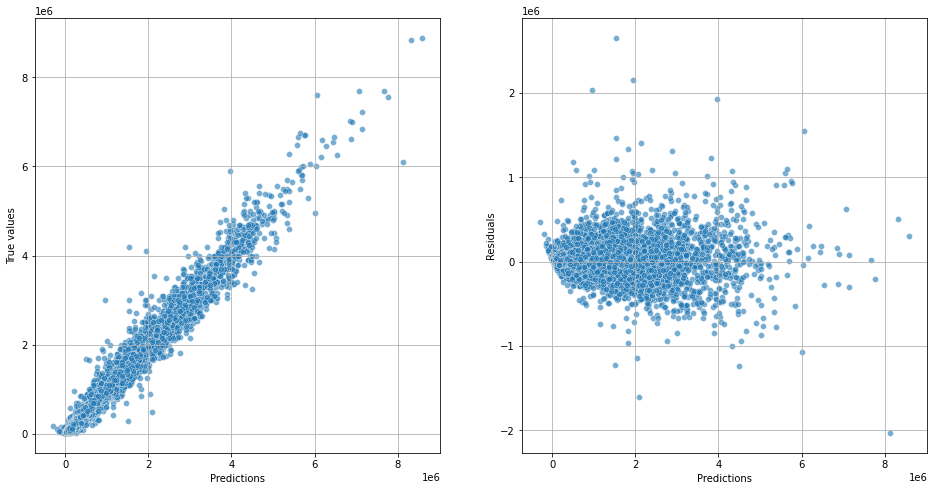

In [154]:
plot_prediction(predictions, y_test)

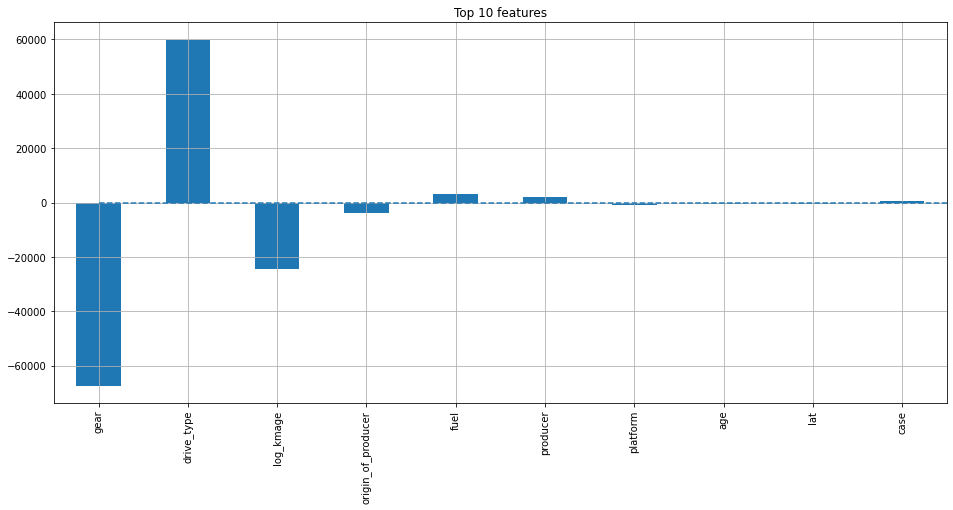

In [155]:
plotCoefficients(lasso, X_train.columns)

### 3.3. RandomForestRegressor

In [53]:
# param_grid = {'n_estimators': [100],
#              'max_depth': [10],
#              'min_samples_leaf': [10]}
# grid = GridSearchCV(RandomForestRegressor(n_jobs=-1), param_grid=param_grid, cv=4)

In [156]:
%%time
rfr = RandomForestRegressor(n_estimators=100, max_depth=5, n_jobs=-1)
rfr.fit(X_train, y_train)

CPU times: user 17min 48s, sys: 317 ms, total: 17min 48s
Wall time: 1min 33s


In [157]:
predictions = rfr.predict(X_test)
print("Mean Absolute Error : {:.2f}".format(mean_absolute_error(predictions, y_test)))

Mean Absolute Error : 63197.88


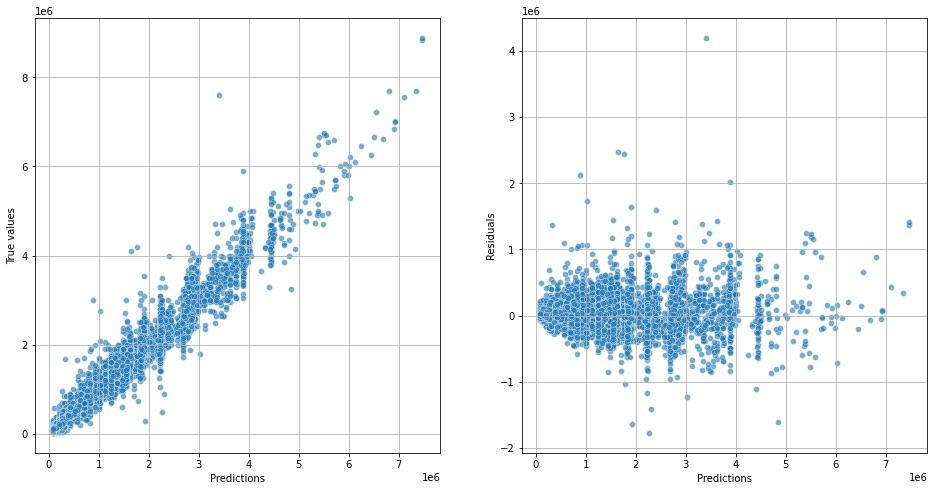

In [158]:
plot_prediction(predictions, y_test)

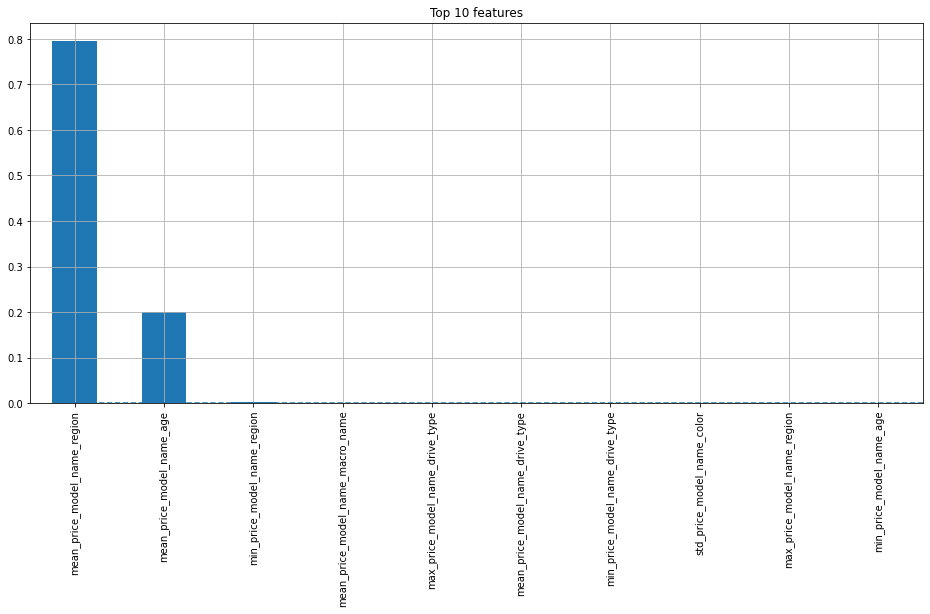

In [159]:
plotCoefficients(rfr, X_train.columns, tree=True)

### 3.4  Boosting models


### 3.4.1 LightGBM

In [160]:
%%time
lgbm_model = LGBMRegressor(n_estimators=1000)
lgbm_model.fit(X_train.values, y_train)

CPU times: user 5min 6s, sys: 506 ms, total: 5min 6s
Wall time: 26.8 s


In [161]:
predictions = lgbm_model.predict(X_test)
print("Mean Absolute Error : {:.2f}".format(mean_absolute_error(predictions, y_test)))

Mean Absolute Error : 44356.43


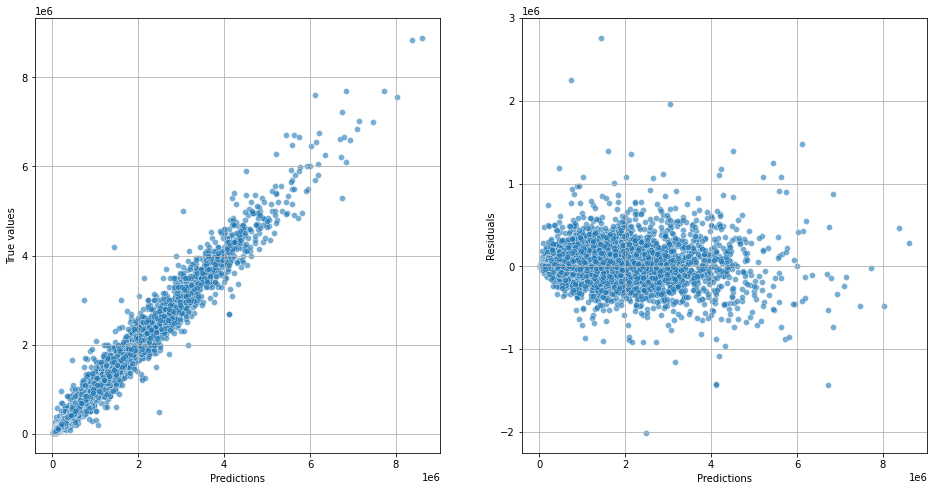

In [162]:
plot_prediction(predictions, y_test)

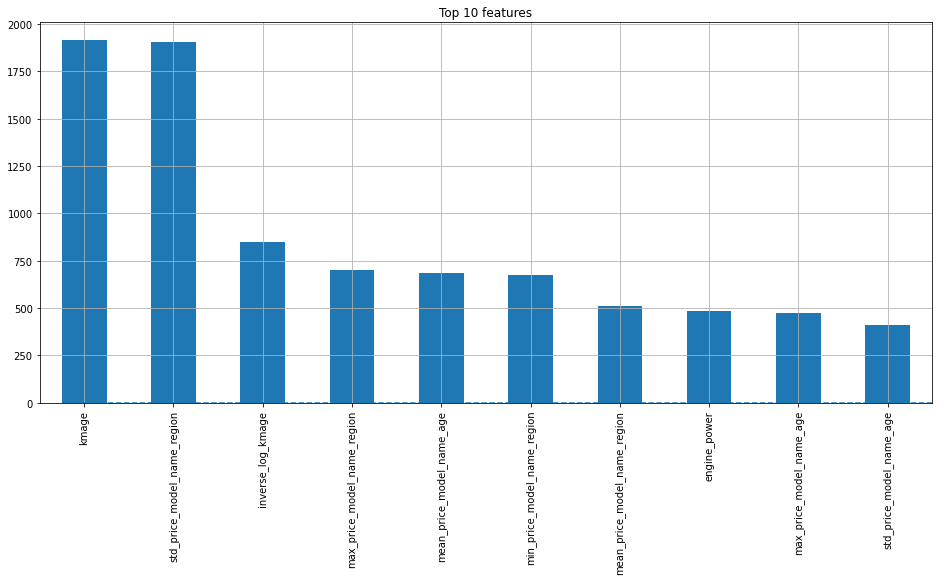

In [163]:
plotCoefficients(lgbm_model, X_train.columns, tree=True)

### Fine tuniing model

In [164]:
model = LGBMRegressor(
        learning_rate= 0.01,
        subsample=0.3,
        feature_fraction=0.5,
        num_iterations = 5000,
        max_bin=350,
        num_leaves= 300,
        lambda_l2=0.003,
        max_depth=200,
        min_data_in_leaf= 80,
        force_row_wise= True,)
        #objective='tweedie')

In [165]:
%%time
model.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_valid,y_valid)],
             eval_metric='rmse',  verbose=100, early_stopping_rounds=20)

/home/mrmopoz/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
[100]	training's rmse: 250610	training's l2: 6.28052e+10	valid_1's rmse: 255442	valid_1's l2: 6.52508e+10
[200]	training's rmse: 123582	training's l2: 1.52726e+10	valid_1's rmse: 129037	valid_1's l2: 1.66506e+10
[300]	training's rmse: 90030.4	training's l2: 8.10548e+09	valid_1's rmse: 98092.4	valid_1's l2: 9.62212e+09
[400]	training's rmse: 81117.7	training's l2: 6.58007e+09	valid_1's rmse: 91610.9	valid_1's l2: 8.39256e+09
[500]	training's rmse: 77420	training's l2: 5.99385e+09	valid_1's rmse: 90012.8	valid_1's l2: 8.10231e+09
[600]	training's rmse: 74828.7	training's l2: 5.59933e+09	valid_1's rmse: 89272.5	valid_1's l2: 7.96958e+09
[700]	training's rmse: 72852	training's l2: 5.30741e+09	valid_1's rmse: 88928.6	valid_1's l2: 7.90829e+09
[800]	training's rmse: 71242.3	training's l2: 5.07547e+09	valid_1's rmse: 88778.4	valid_1's l2: 7.8816e+09
[900]	training's rmse: 69845.8	training's l2: 4.87844e+09	valid_1's rmse: 88642.4	va

LGBMRegressor(feature_fraction=0.5, force_row_wise=True, lambda_l2=0.003,
              learning_rate=0.01, max_bin=350, max_depth=200,
              min_data_in_leaf=80, num_iterations=5000, num_leaves=300,
              subsample=0.3)

In [166]:
predictions = model.predict(X_test)
print("Mean Absolute Error : {:.2f}".format(mean_absolute_error(predictions, y_test)))

Mean Absolute Error : 43343.93


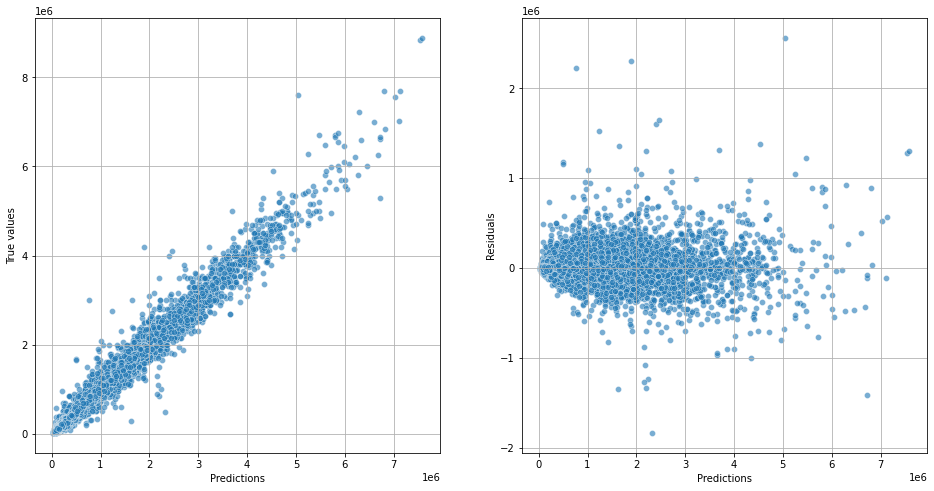

In [167]:
plot_prediction(predictions, y_test)

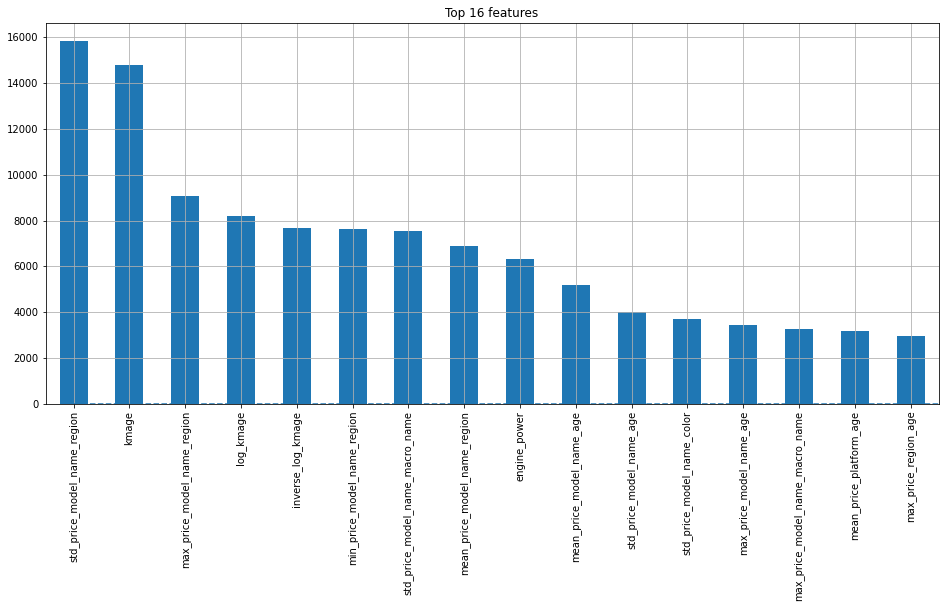

In [168]:
plotCoefficients(model, X_train.columns, tree=True, n_features=16)

### 3.4.2 Catboost

In [169]:
%%time
cat_boost = CatBoostRegressor(n_estimators=1000, learning_rate=0.01)
cat_boost.fit(X_train.values, y_train)

0:	learn: 913543.2745277	total: 98.2ms	remaining: 1m 38s
1:	learn: 904945.1897158	total: 160ms	remaining: 1m 20s
2:	learn: 896409.3797033	total: 212ms	remaining: 1m 10s
3:	learn: 888003.5884719	total: 259ms	remaining: 1m 4s
4:	learn: 879656.7340595	total: 317ms	remaining: 1m 3s
5:	learn: 871386.9045559	total: 367ms	remaining: 1m
6:	learn: 863172.9139863	total: 415ms	remaining: 58.8s
7:	learn: 855083.7125889	total: 478ms	remaining: 59.3s
8:	learn: 847076.9930596	total: 525ms	remaining: 57.8s
9:	learn: 839168.2463586	total: 572ms	remaining: 56.7s
10:	learn: 831310.1563500	total: 621ms	remaining: 55.8s
11:	learn: 823584.5532205	total: 666ms	remaining: 54.8s
12:	learn: 815838.2381018	total: 720ms	remaining: 54.7s
13:	learn: 808195.4810178	total: 768ms	remaining: 54.1s
14:	learn: 800741.1601341	total: 819ms	remaining: 53.8s
15:	learn: 793247.8619797	total: 872ms	remaining: 53.6s
16:	learn: 785801.3540241	total: 921ms	remaining: 53.3s
17:	learn: 778503.7033973	total: 983ms	remaining: 53.6s
1

148:	learn: 251372.9990494	total: 7.13s	remaining: 40.7s
149:	learn: 249555.3697745	total: 7.17s	remaining: 40.7s
150:	learn: 247725.6906404	total: 7.22s	remaining: 40.6s
151:	learn: 245925.5711788	total: 7.26s	remaining: 40.5s
152:	learn: 244163.0897807	total: 7.3s	remaining: 40.4s
153:	learn: 242395.5140123	total: 7.34s	remaining: 40.4s
154:	learn: 240644.1540236	total: 7.4s	remaining: 40.3s
155:	learn: 238935.1939984	total: 7.44s	remaining: 40.3s
156:	learn: 237246.1964170	total: 7.49s	remaining: 40.2s
157:	learn: 235587.9994111	total: 7.54s	remaining: 40.2s
158:	learn: 233921.7797282	total: 7.58s	remaining: 40.1s
159:	learn: 232293.6842849	total: 7.63s	remaining: 40.1s
160:	learn: 230670.1519619	total: 7.68s	remaining: 40s
161:	learn: 229087.1851670	total: 7.72s	remaining: 40s
162:	learn: 227515.4099235	total: 7.77s	remaining: 39.9s
163:	learn: 225936.4048214	total: 7.82s	remaining: 39.9s
164:	learn: 224407.9537960	total: 7.87s	remaining: 39.8s
165:	learn: 222884.1902193	total: 7.9

296:	learn: 126176.7412343	total: 14.3s	remaining: 33.9s
297:	learn: 125918.5199318	total: 14.4s	remaining: 33.8s
298:	learn: 125656.0964571	total: 14.4s	remaining: 33.8s
299:	learn: 125390.0776087	total: 14.5s	remaining: 33.8s
300:	learn: 125152.2165177	total: 14.5s	remaining: 33.7s
301:	learn: 124917.5759288	total: 14.6s	remaining: 33.7s
302:	learn: 124658.3557540	total: 14.6s	remaining: 33.6s
303:	learn: 124420.1745332	total: 14.7s	remaining: 33.6s
304:	learn: 124197.8171056	total: 14.7s	remaining: 33.5s
305:	learn: 123986.6489671	total: 14.8s	remaining: 33.5s
306:	learn: 123745.5691340	total: 14.8s	remaining: 33.4s
307:	learn: 123505.2619250	total: 14.9s	remaining: 33.4s
308:	learn: 123270.7722348	total: 14.9s	remaining: 33.4s
309:	learn: 123046.7743272	total: 15s	remaining: 33.3s
310:	learn: 122823.9237136	total: 15s	remaining: 33.3s
311:	learn: 122610.7348308	total: 15.1s	remaining: 33.3s
312:	learn: 122415.2372944	total: 15.1s	remaining: 33.2s
313:	learn: 122213.0781733	total: 1

441:	learn: 108453.6135138	total: 21.6s	remaining: 27.2s
442:	learn: 108411.4897788	total: 21.6s	remaining: 27.2s
443:	learn: 108364.5867564	total: 21.7s	remaining: 27.1s
444:	learn: 108302.9917318	total: 21.7s	remaining: 27.1s
445:	learn: 108247.0345724	total: 21.7s	remaining: 27s
446:	learn: 108186.5876334	total: 21.8s	remaining: 27s
447:	learn: 108122.0116766	total: 21.8s	remaining: 26.9s
448:	learn: 108075.8850701	total: 21.9s	remaining: 26.9s
449:	learn: 108039.0752461	total: 22s	remaining: 26.8s
450:	learn: 107979.5214771	total: 22s	remaining: 26.8s
451:	learn: 107933.1266865	total: 22.1s	remaining: 26.7s
452:	learn: 107884.2986153	total: 22.1s	remaining: 26.7s
453:	learn: 107842.4567793	total: 22.2s	remaining: 26.7s
454:	learn: 107786.9298212	total: 22.2s	remaining: 26.6s
455:	learn: 107739.9583507	total: 22.3s	remaining: 26.6s
456:	learn: 107697.4990210	total: 22.3s	remaining: 26.5s
457:	learn: 107648.8126135	total: 22.4s	remaining: 26.5s
458:	learn: 107604.4872741	total: 22.4s

586:	learn: 103596.5906842	total: 28.4s	remaining: 20s
587:	learn: 103576.0142738	total: 28.5s	remaining: 19.9s
588:	learn: 103561.1564694	total: 28.5s	remaining: 19.9s
589:	learn: 103529.3293275	total: 28.6s	remaining: 19.8s
590:	learn: 103504.7411144	total: 28.6s	remaining: 19.8s
591:	learn: 103487.7606616	total: 28.6s	remaining: 19.7s
592:	learn: 103472.7632905	total: 28.7s	remaining: 19.7s
593:	learn: 103453.2701954	total: 28.7s	remaining: 19.6s
594:	learn: 103438.2585133	total: 28.8s	remaining: 19.6s
595:	learn: 103417.7326411	total: 28.8s	remaining: 19.5s
596:	learn: 103392.0186330	total: 28.9s	remaining: 19.5s
597:	learn: 103377.5878441	total: 28.9s	remaining: 19.4s
598:	learn: 103356.0541162	total: 29s	remaining: 19.4s
599:	learn: 103334.5884890	total: 29s	remaining: 19.3s
600:	learn: 103311.3996070	total: 29s	remaining: 19.3s
601:	learn: 103287.3254558	total: 29.1s	remaining: 19.2s
602:	learn: 103265.6790811	total: 29.1s	remaining: 19.2s
603:	learn: 103246.0252354	total: 29.2s

733:	learn: 100803.9376674	total: 34.8s	remaining: 12.6s
734:	learn: 100793.9021998	total: 34.9s	remaining: 12.6s
735:	learn: 100776.1735865	total: 34.9s	remaining: 12.5s
736:	learn: 100763.6390283	total: 35s	remaining: 12.5s
737:	learn: 100749.5125865	total: 35s	remaining: 12.4s
738:	learn: 100739.9915091	total: 35s	remaining: 12.4s
739:	learn: 100727.0028321	total: 35.1s	remaining: 12.3s
740:	learn: 100712.6700489	total: 35.1s	remaining: 12.3s
741:	learn: 100702.3541729	total: 35.2s	remaining: 12.2s
742:	learn: 100678.6106138	total: 35.2s	remaining: 12.2s
743:	learn: 100665.2539207	total: 35.3s	remaining: 12.1s
744:	learn: 100643.1722515	total: 35.3s	remaining: 12.1s
745:	learn: 100626.7859263	total: 35.3s	remaining: 12s
746:	learn: 100613.2349100	total: 35.4s	remaining: 12s
747:	learn: 100593.5234140	total: 35.4s	remaining: 11.9s
748:	learn: 100583.3857786	total: 35.5s	remaining: 11.9s
749:	learn: 100567.2438711	total: 35.5s	remaining: 11.8s
750:	learn: 100553.4990992	total: 35.6s	r

883:	learn: 98457.6449699	total: 41.5s	remaining: 5.44s
884:	learn: 98441.8655897	total: 41.5s	remaining: 5.39s
885:	learn: 98424.9477291	total: 41.6s	remaining: 5.35s
886:	learn: 98412.6032338	total: 41.6s	remaining: 5.3s
887:	learn: 98401.6012027	total: 41.6s	remaining: 5.25s
888:	learn: 98384.8520721	total: 41.7s	remaining: 5.21s
889:	learn: 98372.6859204	total: 41.7s	remaining: 5.16s
890:	learn: 98364.6134668	total: 41.8s	remaining: 5.11s
891:	learn: 98351.0475858	total: 41.8s	remaining: 5.06s
892:	learn: 98335.2046219	total: 41.9s	remaining: 5.02s
893:	learn: 98319.3037347	total: 41.9s	remaining: 4.97s
894:	learn: 98293.8351643	total: 42s	remaining: 4.92s
895:	learn: 98284.2215658	total: 42s	remaining: 4.88s
896:	learn: 98273.7713234	total: 42.1s	remaining: 4.83s
897:	learn: 98258.1608902	total: 42.1s	remaining: 4.78s
898:	learn: 98241.9315123	total: 42.1s	remaining: 4.74s
899:	learn: 98227.9488797	total: 42.2s	remaining: 4.69s
900:	learn: 98219.5814850	total: 42.2s	remaining: 4.6

In [170]:
predictions = cat_boost.predict(X_test.values)
print("Mean Absolute Error : {:.2f}".format(mean_absolute_error(predictions, y_test)))

Mean Absolute Error : 59069.21


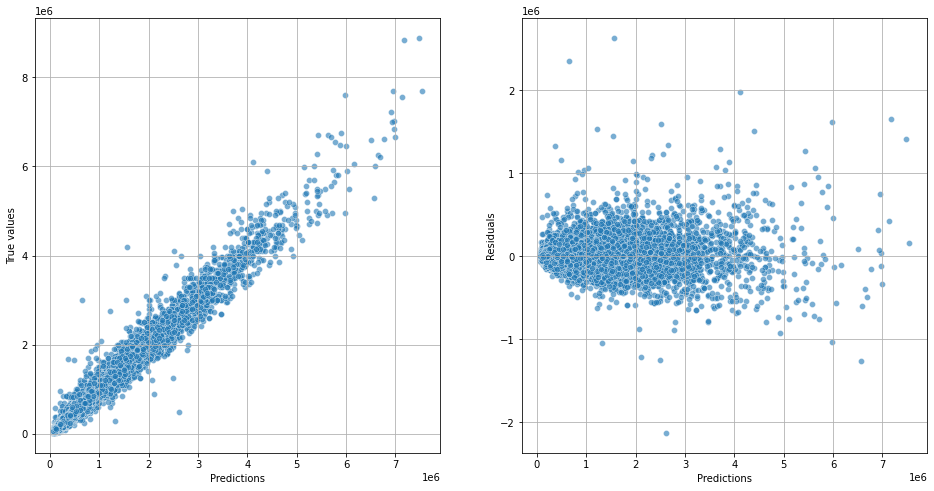

In [171]:
plot_prediction(predictions, y_test)

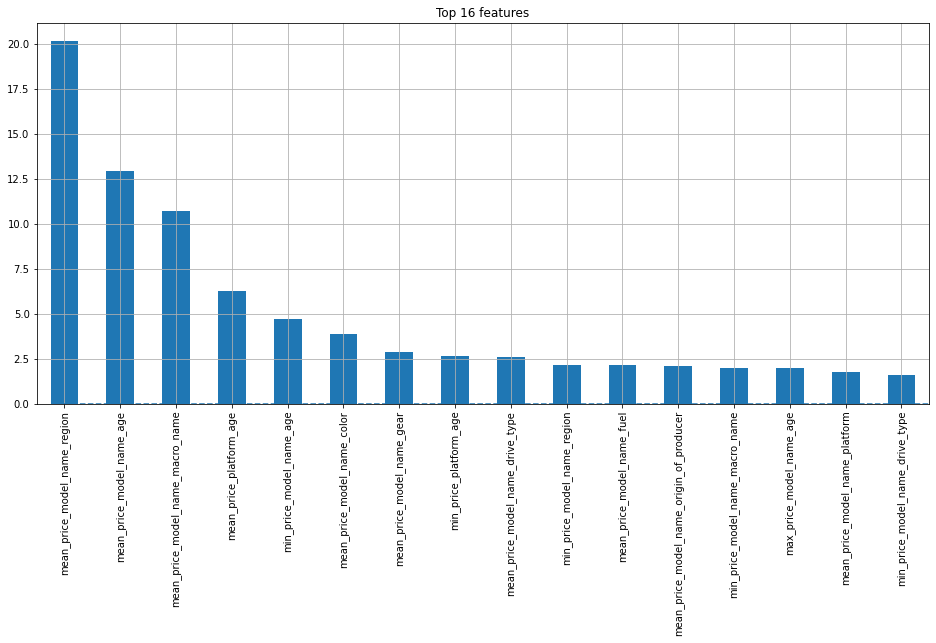

In [172]:
plotCoefficients(cat_boost, X_train.columns, tree=True, n_features=16)

## TODO:

1. Generate new features
2. Look at  observations where models error, find features that determine errors
3. look at oabservations where all models error, find features that determine errors
4. Model composition/stacking
5. Select features